The datasets in which we will be using here were obtained via open sources.

---

Let's begin with importing our needed libraries.

In [1]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
from sklearn import metrics
import pandas as pd
import numpy as np
%matplotlib inline

The primary weakness of decision trees is that they tend to not have the best predictive accuracy. Let's try manually implementing bagged decision trees (with B=10).

In [2]:
# Let's set a seed for reproducibility #
np.random.seed(42)

# Let's create an array of 1 through 20 #
nums = np.arange(1, 21)
print(nums)

# Now, let's sample that array 20 times with replacement #
print(np.random.choice(a=nums, size=20, replace=True))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
[ 7 20 15 11  8  7 19 11 11  4  8  3  2 12  6  2  1 12 12 17]


In [3]:
# Next, let's read in and prepare the vehicle training data #
path = './data/vehicles_train.csv'
train = pd.read_csv(path)
train['vtype'] = train.vtype.map({'car':0, 'truck':1})
train

,price,year,miles,doors,vtype
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [4]:
# Let's set a seed for reproducibility #
np.random.seed(42)

# Now, let's create ten bootstrap samples (which will be used to select rows from the DataFrame) #
samples = [np.random.choice(a=14, size=14, replace=True) for _ in range(1, 11)]
samples

[array([ 6,  3, 12, 10,  7, 12,  4,  6,  9,  2,  6, 10, 10,  7]),
 array([ 4,  3,  7,  7,  2,  5,  4,  1,  7, 11, 13,  5,  1, 11]),
 array([ 4,  0, 11,  9,  5, 12, 11,  8,  0, 10, 10,  9, 11, 11]),
 array([13, 13, 13,  2, 11,  6,  3,  8,  2,  4,  2,  6,  4,  8]),
 array([ 6,  1,  3,  8, 11, 13,  1,  9,  8,  9,  4,  1,  3, 11]),
 array([11,  6, 11, 12,  7,  2, 13,  0,  3,  1,  7,  3,  1, 13]),
 array([ 5,  5,  9,  3,  5, 12,  1,  9, 11,  1,  9, 13,  3, 13]),
 array([ 7, 13,  6, 11,  8, 13,  7,  4, 12,  1,  4,  7,  9,  8]),
 array([11, 11, 11, 12,  8, 12, 12,  0,  8,  6,  8,  7,  0, 11]),
 array([ 7,  7, 10,  2,  0,  7,  2,  2,  0, 10,  4,  9,  6,  9])]

In [5]:
# Let's show the rows for the first decision tree #
train.iloc[samples[0], :]

,price,year,miles,doors,vtype
6,3000,2004,177000,4,0
3,9500,2009,78000,4,0
12,1800,1999,163000,2,1
10,2500,2003,190000,2,1
7,2000,2004,209000,4,1
12,1800,1999,163000,2,1
4,9000,2007,47000,4,0
6,3000,2004,177000,4,0
9,1900,2003,160000,4,0
2,13000,2010,73500,4,0


In [6]:
# Next, let's read in and prepare the vehicle testing data #
path = './data/vehicles_test.csv'
test = pd.read_csv(path)
test['vtype'] = test.vtype.map({'car':0, 'truck':1})
test

,price,year,miles,doors,vtype
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [7]:
# Next, let's grow each tree deep #
treereg = DecisionTreeRegressor(max_depth=None, random_state=42)

# Let's create a list for storing predicted price from each tree #
predictions = []

# Let's define the testing data #
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

# Next, let's grow one tree for each bootstrap sample and make predictions on the testing data #
for sample in samples:
    X_train = train.iloc[sample, 1:]
    y_train = train.iloc[sample, 0]
    treereg.fit(X_train, y_train)
    y_pred = treereg.predict(X_test)
    predictions.append(y_pred)

# Now, let's convert predictions from a list to an array #
predictions = np.array(predictions)
predictions

array([[ 1800.,  1900., 13000.],
       [ 5000.,  5000., 14000.],
       [ 3000.,  5000., 22000.],
       [ 3000.,  5000., 13000.],
       [ 3000.,  5000.,  9500.],
       [ 1800.,  5000., 13000.],
       [ 5000.,  5000., 14000.],
       [ 3000.,  5000., 14000.],
       [ 2000.,  5000., 22000.],
       [ 1900.,  1900., 22000.]])

In [8]:
# Let's average the predictions #
np.mean(predictions, axis=0)

array([ 2950.,  4380., 15650.])

In [9]:
# Let's calculate the RMSE #
y_pred = np.mean(predictions, axis=0)
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

2305.746444574222

Let's try creating bagged decision trees using scikit-learn (with B=500).

In [10]:
# Let's define the training and testing sets #
X_train = train.iloc[:, 1:]
y_train = train.iloc[:, 0]
X_test = test.iloc[:, 1:]
y_test = test.iloc[:, 0]

In [11]:
# Let's instruct BaggingRegressor to use DecisionTreeRegressor as the "base estimator" #
bagreg = BaggingRegressor(DecisionTreeRegressor(), n_estimators=500, bootstrap=True, oob_score=True, random_state=42)

In [12]:
# Next, let's fit and predict #
bagreg.fit(X_train, y_train)
y_pred = bagreg.predict(X_test)
y_pred

array([ 3339. ,  5517.2, 12902. ])

In [13]:
# Now, let's calculate the RMSE #
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

622.2595492772022

For bagged models, out-of-sample error can be estimated without using train/test split or cross-validation. Thus, for each tree, the unused observations are called "out-of-bag" observations.

In [14]:
# Let's show the first bootstrap sample #
samples[0]

array([ 6,  3, 12, 10,  7, 12,  4,  6,  9,  2,  6, 10, 10,  7])

In [15]:
# Let's show the "in-bag" observations for each sample #
for sample in samples:
    print(set(sample))

{2, 3, 4, 6, 7, 9, 10, 12}
{1, 2, 3, 4, 5, 7, 11, 13}
{0, 4, 5, 8, 9, 10, 11, 12}
{2, 3, 4, 6, 8, 11, 13}
{1, 3, 4, 6, 8, 9, 11, 13}
{0, 1, 2, 3, 6, 7, 11, 12, 13}
{1, 3, 5, 9, 11, 12, 13}
{1, 4, 6, 7, 8, 9, 11, 12, 13}
{0, 6, 7, 8, 11, 12}
{0, 2, 4, 6, 7, 9, 10}


In [16]:
# Now, let's show the "out-of-bag" observations for each sample #
for sample in samples:
    print(sorted(set(range(14)) - set(sample)))

[0, 1, 5, 8, 11, 13]
[0, 6, 8, 9, 10, 12]
[1, 2, 3, 6, 7, 13]
[0, 1, 5, 7, 9, 10, 12]
[0, 2, 5, 7, 10, 12]
[4, 5, 8, 9, 10]
[0, 2, 4, 6, 7, 8, 10]
[0, 2, 3, 5, 10]
[1, 2, 3, 4, 5, 9, 10, 13]
[1, 3, 5, 8, 11, 12, 13]


In [17]:
# Let's compute the out-of-bag R-squared score for B=500 #
bagreg.oob_score_

0.8015524904740718

When B is sufficiently large, the out-of-bag error is an accurate estimate of out-of-sample error. Random Forests offer a slight variation on bagged trees with even better performance.

In [18]:
# Let's read in the data #
path ='./data/hitters.csv'
hitters = pd.read_csv(path)

# Let's remove rows with missing values.
hitters.dropna(inplace=True)

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,N,W,632,43,10,475.0,N
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,A,W,880,82,14,480.0,A
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,N,E,200,11,3,500.0,N
4,321,87,10,39,42,30,2,396,101,12,48,46,33,N,E,805,40,4,91.5,N
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,A,W,282,421,25,750.0,A


In [19]:
# Let's encode the categorical variables as integers #
hitters['League'] = pd.factorize(hitters.League)[0]
hitters['Division'] = pd.factorize(hitters.Division)[0]
hitters['NewLeague'] = pd.factorize(hitters.NewLeague)[0]

hitters.head()

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,0,0,632,43,10,475.0,0
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,1,0,880,82,14,480.0,1
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,0,1,200,11,3,500.0,0
4,321,87,10,39,42,30,2,396,101,12,48,46,33,0,1,805,40,4,91.5,0
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,1,0,282,421,25,750.0,1


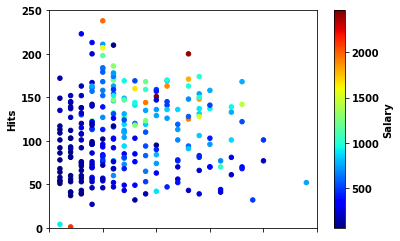

In [20]:
# Let's create a scatter plot of hits vs years, colored by salary #
hitters.plot(kind='scatter', x='Years', y='Hits', c='Salary', colormap='jet', xlim=(0, 25), ylim=(0, 250));

In [21]:
# Let's define the features: excluding career statistics (which start with "C") and the response (salary) #
feature_cols = hitters.columns[hitters.columns.str.startswith('C') == False].drop('Salary')
feature_cols

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'League',
       'Division', 'PutOuts', 'Assists', 'Errors', 'NewLeague'],
      dtype='object')

In [22]:
# Let's define X and y.
X = hitters[feature_cols]
y = hitters.Salary

Let's quickly recall how we might predict salary using a single decision tree.

In [23]:
# First, let's create a list of values to try for max_depth #
max_depth_range = list(range(1, 21))

# Next, let's create a list to store the average RMSE for each value of max_depth #
RMSE_scores = []

# Now, let's use 10-fold cross-validation with each value of max_depth #
for depth in max_depth_range:
    treereg = DecisionTreeRegressor(max_depth=depth, random_state=42)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

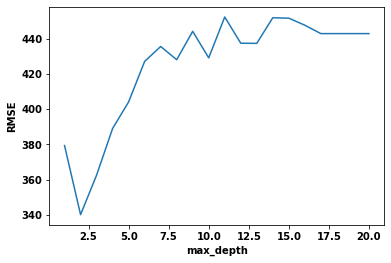

In [24]:
# Let's plot RMSE vs max_depth #
plt.plot(max_depth_range, RMSE_scores);
plt.xlabel('max_depth');
plt.ylabel('RMSE');

In [25]:
# Let's see the best RMSE and its corresponding max_depth #
sorted(zip(RMSE_scores, max_depth_range))[0]

(340.034168704752, 2)

In [26]:
# We see that max_depth=2 was best, so let's fit a tree using that parameter #
treereg = DecisionTreeRegressor(max_depth=2, random_state=42)
treereg.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=42, splitter='best')

In [27]:
# Let's compute the feature importances #
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values(by='importance')

,feature,importance
0,AtBat,0.000000
2,HmRun,0.000000
3,Runs,0.000000
4,RBI,0.000000
7,League,0.000000
8,Division,0.000000
9,PutOuts,0.000000
10,Assists,0.000000
11,Errors,0.000000
12,NewLeague,0.000000


Now, let's predict salary with a random forest by fitting a random forest with the best parameters.

In [28]:
# max_features=5 is best and n_estimators=150 is sufficiently large #
rfreg = RandomForestRegressor(n_estimators=150, max_features=5, oob_score=True, random_state=42)
rfreg.fit(X, y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features=5, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=150,
                      n_jobs=None, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [29]:
# Let's compute the feature importances #
pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

,feature,importance
12,NewLeague,0.004917
7,League,0.005929
8,Division,0.010205
10,Assists,0.027183
11,Errors,0.028777
2,HmRun,0.049172
9,PutOuts,0.061429
3,Runs,0.073913
0,AtBat,0.101450
4,RBI,0.123655


In [30]:
# Let's compute the out-of-bag R-squared score #
print((rfreg.oob_score_))

# Let's also find the average RMSE #
scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.5168638277648683


289.91285074592514

Often, parameter tuning is required to achieve optimal results.

In [31]:
rfreg = RandomForestRegressor()
rfreg

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [32]:
# Let's create a list of values to try for n_estimators #
estimator_range = list(range(10, 310, 10))

# Let's create a list to store the average RMSE for each value of n_estimators #
RMSE_scores = []

# Now, let's use five-fold cross-validation with each value of n_estimators #
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=42)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

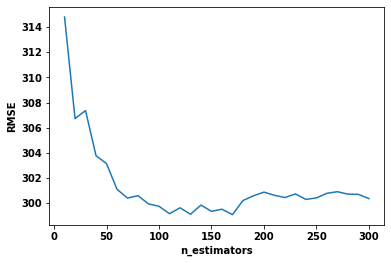

In [33]:
# Let's plot RMSE vs n_estimators #
plt.plot(estimator_range, RMSE_scores);
plt.xlabel('n_estimators');
plt.ylabel('RMSE');

In [34]:
# Let's see the best RMSE and its corresponding n_estimators #
sorted(zip(RMSE_scores, estimator_range))[0]

(299.0878643356646, 170)

In [35]:
# Let's create a list of values to try for max_features #
feature_range = list(range(1, len(feature_cols)+1))

# Let's create a list to store the average RMSE for each value of max_features #
RMSE_scores = []

# Now, let's use 10-fold cross-validation with each value of max_features #
for feature in feature_range:
    rfreg = RandomForestRegressor(n_estimators=150, max_features=feature, random_state=42)
    MSE_scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

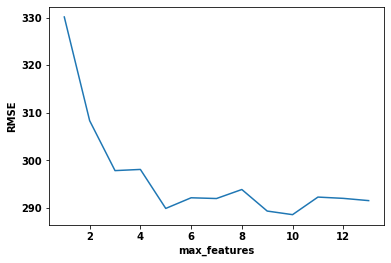

In [36]:
# Let's plot RMSE vs max_features #
plt.plot(feature_range, RMSE_scores);
plt.xlabel('max_features');
plt.ylabel('RMSE');

In [37]:
# Let's see the best RMSE and its corresponding max_features #
sorted(zip(RMSE_scores, feature_range))[0]

(288.60586111707744, 10)

In [38]:
# Now, let's compare our previous results with our new results after parameter tuning #
rfreg = RandomForestRegressor(n_estimators=170, max_features=10, oob_score=True, random_state=42)
rfreg.fit(X, y)

print((rfreg.oob_score_))

scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.5217188173523861


287.792703464171